# Importing the required packages

In [1]:
import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt

# Defining the model

The model that I have used is a simple fully connected one with one hidden layer in each of the parts( i.e. Encoder and Decoder).

<img src = "/Architecture.png" />

In [2]:
class VAE(nn.Module):
  
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 400)
        self.fc2_mu = nn.Linear(400, 20)
        self.fc2_sig = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)
  
    def encode(self,x):
        a1 = F.relu(self.fc1(x))
        a_mu = self.fc2_mu(a1)
        a_logvar = self.fc2_sig(a1)
        return a_mu, a_logvar
  
    def decode(self,z):
        a3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(a3))
  
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)
  
    def forward(self,x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

## Getting the Dataset

In [3]:
train_dataset = torchvision.datasets.MNIST(root='./data',train=True, transform=transforms.ToTensor(), download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',train=False, transform=transforms.ToTensor(),download = True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,  batch_size=100, shuffle=False)

## Instantiating the model and Optimizer

In [4]:
model = VAE()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Defining the loss function

The loss consists of two parts :-
1. The cross entropy loss between the original and reconstructed image
2. The KL Divergence between Q(z|x) and P(z|X). This loss makes the learned distribution on z to be similar to some assumed distribution(Gaussian in this case). For more on this, read this [tutorial](https://arxiv.org/pdf/1606.05908). Formula is derived on Appendix B of the [paper](https://arxiv.org/pdf/1312.6114).

In [5]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

# Training

In [6]:
num_epochs = 5
print_per = 100
model.train()
loss_record = []
for epoch in range(num_epochs):
    train_loss = 0
    print_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.reshape(-1, 28*28)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(images)
        loss = loss_function(recon_batch, images, mu, logvar)
        loss.backward()
        if (epoch == 0):
            loss_record.append(loss.item())
        train_loss += loss.item()
        print_loss += loss.item()
        optimizer.step()
        
        if (i%print_per == 0):
            print("Epoch : {} , Minibatch : {} Loss = {:.4f}".format(epoch+1, i, print_loss))
#             loss_record.append(print_loss)
            print_loss = 0
    print("Epoch {} : Loss = ({:.4f}) ".format(epoch+1, train_loss))

Epoch : 1 , Minibatch : 0 Loss = 54789.6172
Epoch : 1 , Minibatch : 100 Loss = 2296336.5566
Epoch : 1 , Minibatch : 200 Loss = 1641241.8613
Epoch : 1 , Minibatch : 300 Loss = 1460765.7021
Epoch : 1 , Minibatch : 400 Loss = 1366460.5518
Epoch : 1 , Minibatch : 500 Loss = 1306802.2734
Epoch 1 : Loss = (9380086.2510) 
Epoch : 2 , Minibatch : 0 Loss = 11909.7256
Epoch : 2 , Minibatch : 100 Loss = 1230171.1699
Epoch : 2 , Minibatch : 200 Loss = 1209696.3896
Epoch : 2 , Minibatch : 300 Loss = 1185796.5020
Epoch : 2 , Minibatch : 400 Loss = 1173013.1475
Epoch : 2 , Minibatch : 500 Loss = 1170144.8301
Epoch 2 : Loss = (7125041.2344) 
Epoch : 3 , Minibatch : 0 Loss = 10819.3555
Epoch : 3 , Minibatch : 100 Loss = 1149355.5850
Epoch : 3 , Minibatch : 200 Loss = 1136657.8994
Epoch : 3 , Minibatch : 300 Loss = 1129757.7314
Epoch : 3 , Minibatch : 400 Loss = 1127398.5312
Epoch : 3 , Minibatch : 500 Loss = 1122224.3330
Epoch 3 : Loss = (6785680.2803) 
Epoch : 4 , Minibatch : 0 Loss = 11511.7969
Epoch

## Loss record

As we can clearly see, the loss is decreasing as we pass more and more number of batches i.e. as we perform more number of iterations. The losses here are only for the first epoch. The fluctuations are due to the use of mini batch gradient descent.

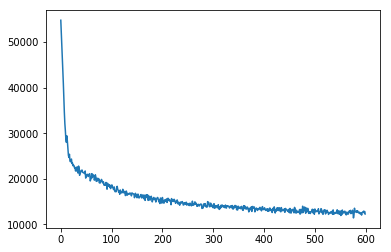

In [7]:
plt.plot(loss_record)

Reconstructing a random image from the training set :-

(784,)
torch.Size([784])


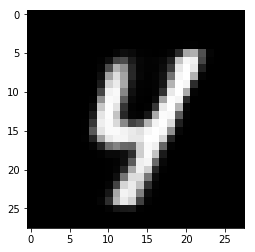

In [8]:
print(model(images)[0].data[0].numpy().shape)
image1 = images[8]
print(image1.shape)
plt.imshow(model(images)[0].data[8].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

Reconstructing images from the test set :-

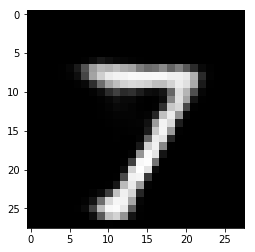

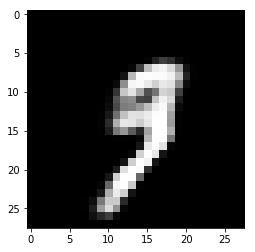

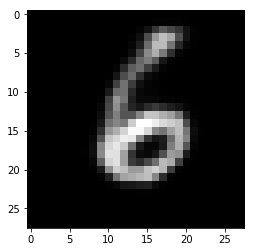

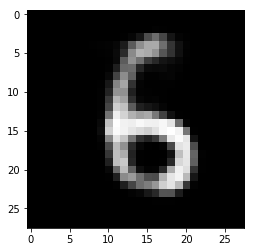

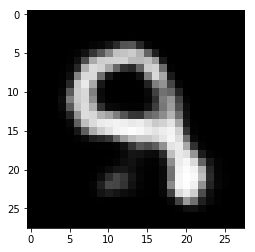

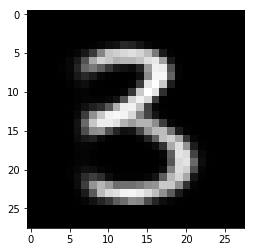

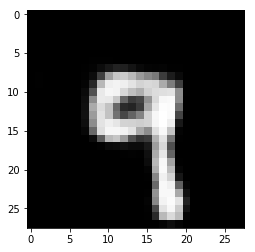

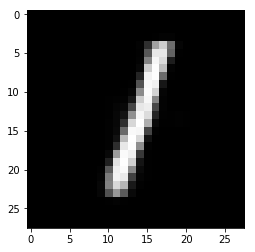

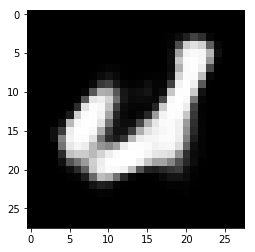

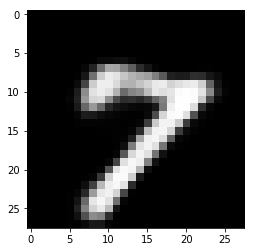

In [9]:
test_loss = 0
print_per = 10
with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        images = images.reshape(-1, 28*28)
        recon_batch, mu, logvar = model(images)
        test_loss += loss_function(recon_batch, images, mu, logvar).item()
        if (i%print_per == 0):
            plt.imshow(model(images)[0].data[0].numpy().reshape(28, 28), cmap='gray')
            plt.show(block=True)

In [10]:
image2 = images[1]
print(image2.shape)

torch.Size([784])


Original image of some random training example :-

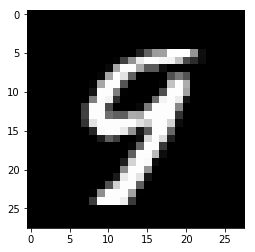

In [11]:
plt.imshow(images[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

Reconstructed image :-

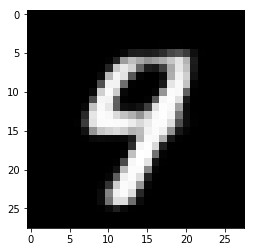

In [12]:
plt.imshow(model(images)[0].data[1].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

# Experiments

First we will calculate mu, logvar fomr two images by passing them through the encoder of our network. We will use them later to perform some experiments

In [13]:
with torch.no_grad():
    mu1, logvar1 = model.encode(image1)
    std1 = torch.exp(0.5*logvar1)
    mu2, logvar2 = model.encode(image2)
    std2 = torch.exp(0.5*logvar2)

### 1. Sampling epsilon values at regular intervals and reconstructing the images

We can see that the reconstructed images are not actually same, i.e. their values differ but the look very similar. This means that our network tries to maps many z values (following a particular gaussian) to a singe image.

In [14]:
with torch.no_grad():
    recon_images1 = []
    for ctr in range(0, 100, 5):
        eps_val = torch.full_like(mu1, fill_value = ctr * 0.01 )
        z_val1 = eps_val.mul(std1).add_(mu1)
        recon_image1 = model.decode(z_val1)
        recon_images1.append(recon_image1)

In [15]:
print(recon_images1[0] - recon_images1[1])

tensor([-1.6100e-07, -1.3919e-07, -1.3006e-07, -1.1566e-07, -1.8562e-07,
        -1.9818e-07, -5.0689e-08, -6.3592e-08, -1.2538e-07, -1.0813e-07,
        -1.3024e-07, -1.3028e-07, -9.6279e-08, -1.3603e-07, -8.6742e-08,
        -2.3373e-07, -1.2368e-07, -1.2435e-07, -6.2805e-08, -1.3062e-07,
        -1.4138e-07, -9.8231e-08, -1.2456e-07, -1.3576e-07, -1.4953e-07,
        -4.7374e-08, -1.9469e-07, -5.9462e-08, -1.4301e-07, -1.1349e-07,
        -1.1179e-07, -1.4580e-07, -1.8958e-07, -4.3240e-08, -4.9798e-07,
        -2.2435e-07, -7.3589e-08, -3.9425e-08, -1.8130e-08, -3.3894e-08,
        -4.6831e-08, -3.8189e-07, -3.1367e-08, -2.0034e-08, -2.5450e-08,
        -6.5139e-08, -7.0388e-08, -8.4171e-08, -3.9361e-08, -9.1399e-08,
        -2.6605e-07, -3.0941e-07, -5.7522e-08, -1.4839e-07, -1.2714e-07,
        -8.8617e-08, -1.1333e-07, -1.1149e-07, -1.1908e-07, -1.1789e-07,
        -1.2540e-07, -2.5440e-07, -1.1480e-07, -3.0591e-08, -3.2753e-08,
        -4.6992e-08, -2.6790e-08, -3.2021e-08, -7.2

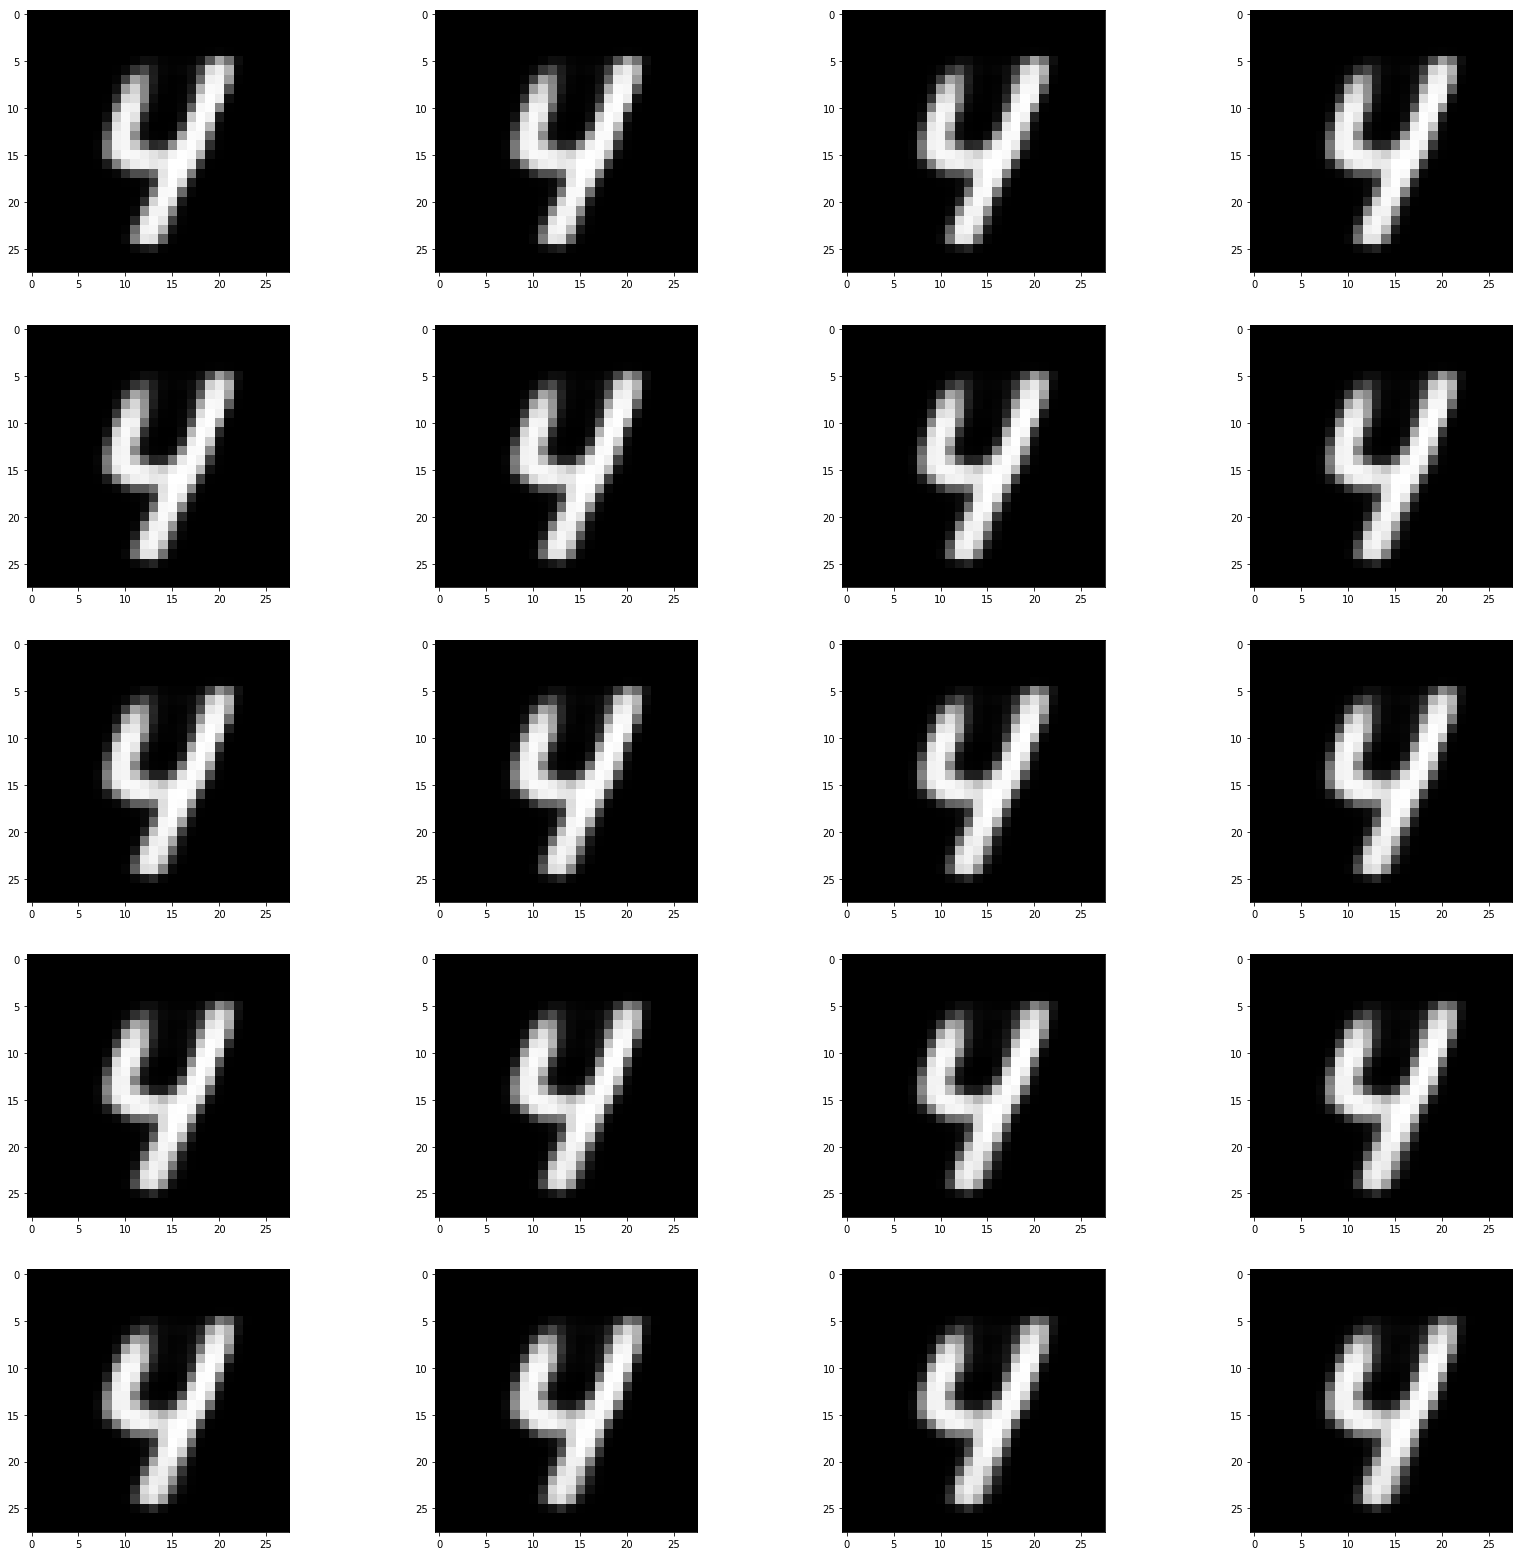

In [16]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

### 2. Changing just one dimension of the latent variable and reconstructing the images

This doesn't affect the constructed images a lot since we have 19 more dimensions which point to the same digit so changing one dimension doesn't create a visual effect.

In [17]:
with torch.no_grad():
    recon_images1 = []
    eps_val = torch.randn_like(mu1)
    for ctr in range(0, 100, 5):
        eps_val[7] = ctr * 0.05 * std1[7] + mu1[7]
        z_val1 = eps_val.mul(std1).add_(mu1)
        recon_image1 = model.decode(z_val1)
        recon_images1.append(recon_image1)

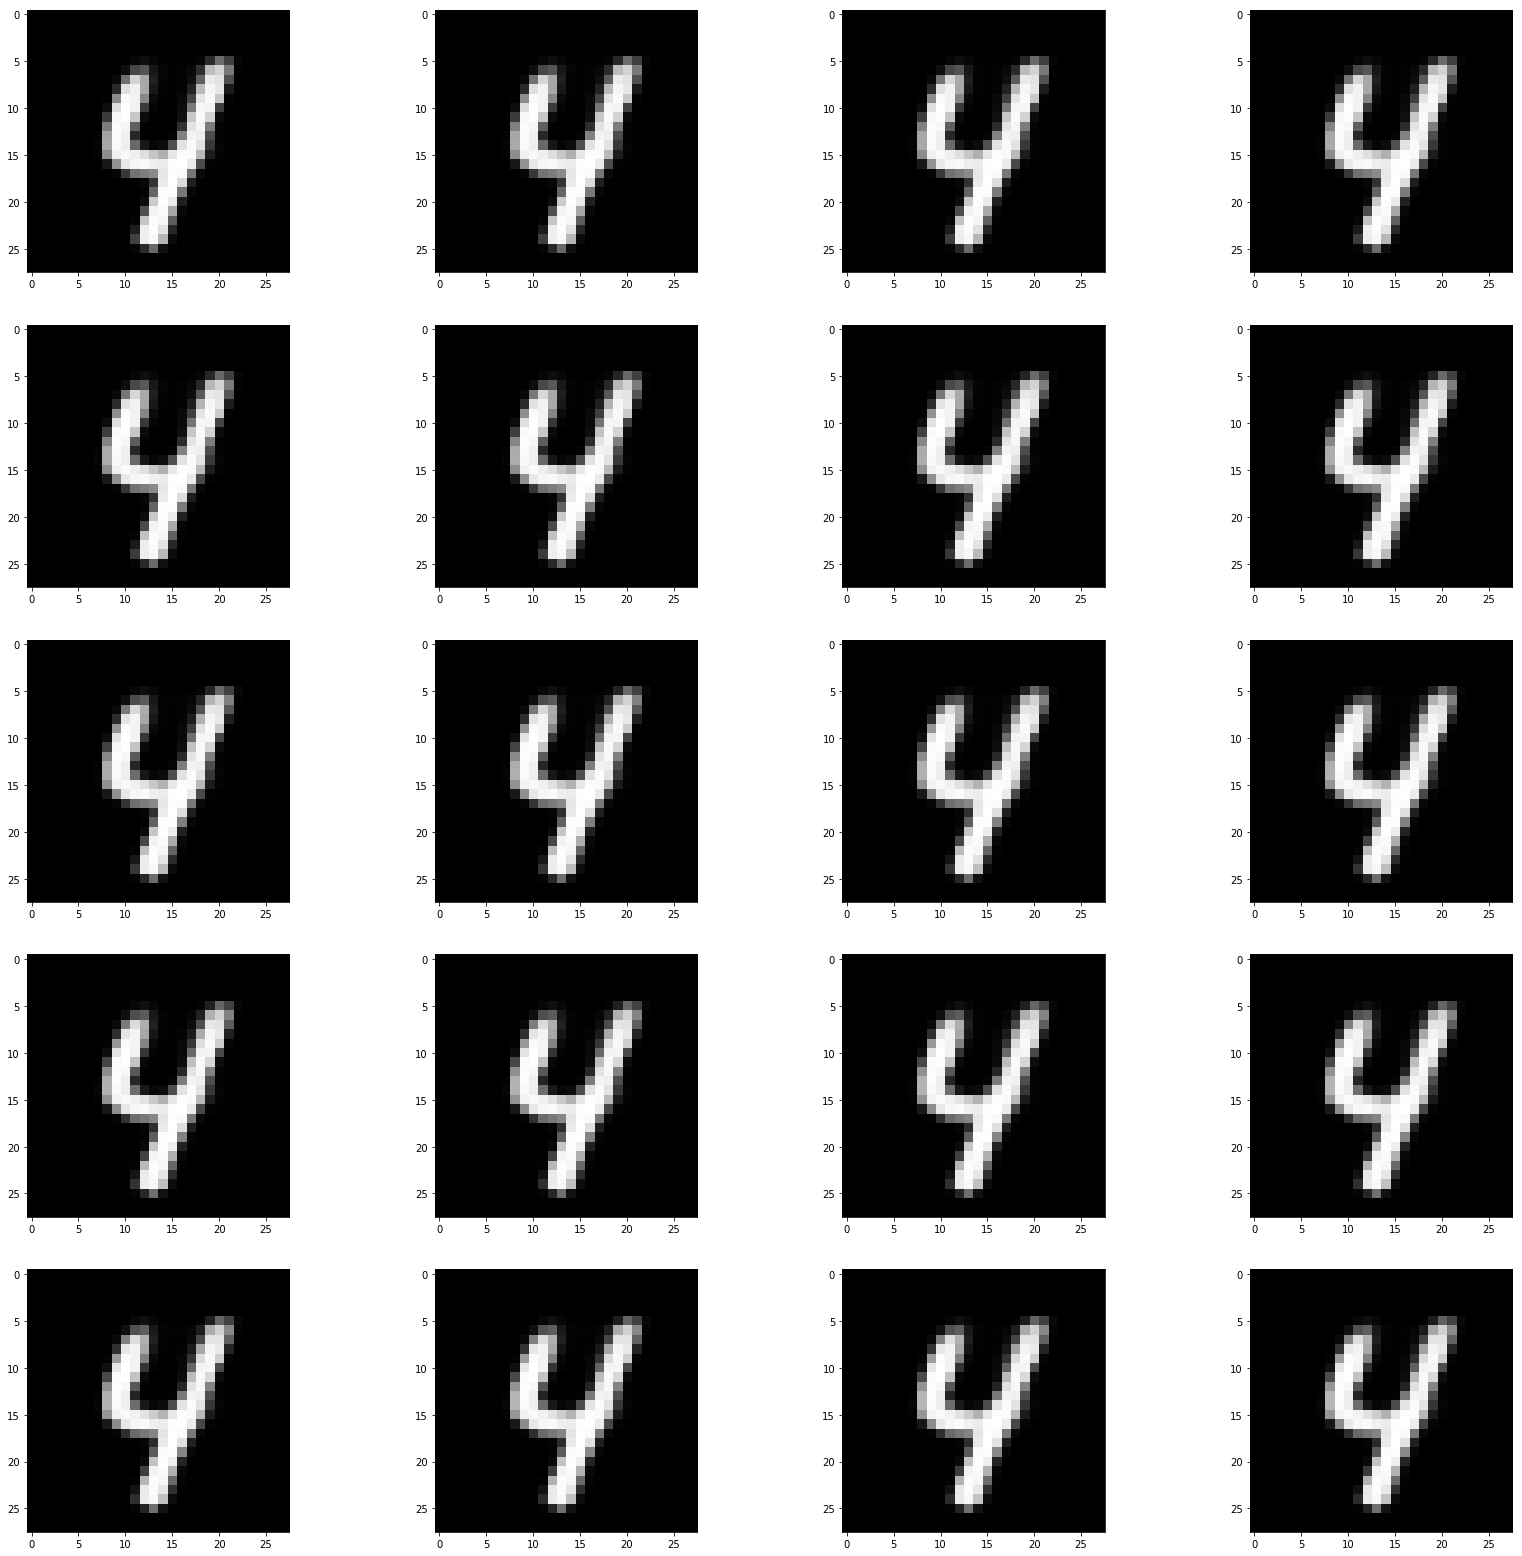

In [18]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = recon_images1[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()

### 3. Transitioning from one digit image to another digit image in the latent space and reconstructing images at regular intervals

It is important to note that we have used the same value of epsilon to construct z from the images. 

In [19]:
eps_any = torch.randn_like(mu1)
z1 = eps_any.mul(std1).add_(mu1)
z2 = eps_any.mul(std2).add_(mu2)
all_recons = []
for i in range(20):
    z_bet = z1 + torch.full_like(mu1, fill_value = 0.05*i).mul(z2 - z1)
    recon_image = model.decode(z_bet)
    all_recons.append(recon_image)

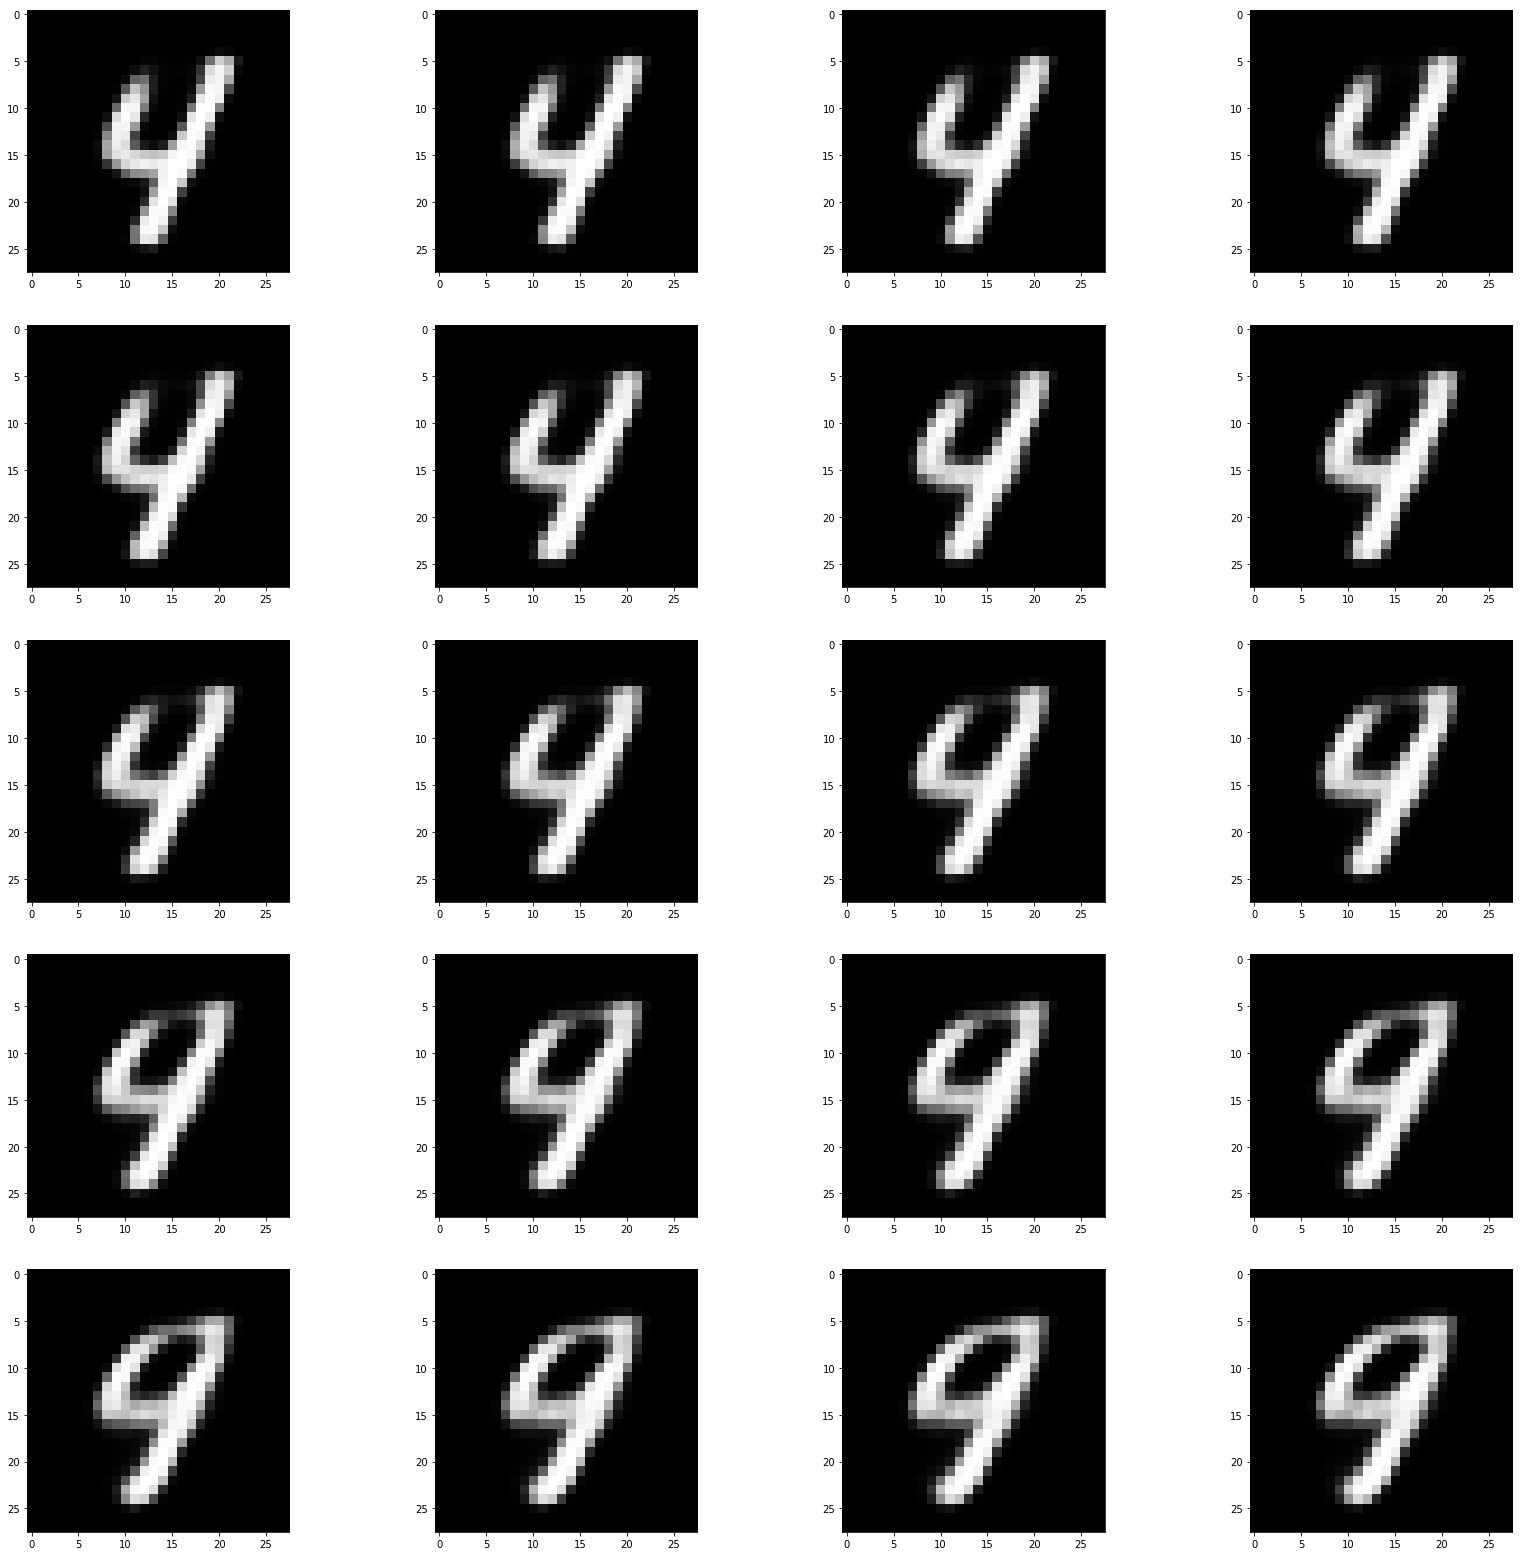

In [20]:
fig=plt.figure(figsize=(28, 28))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = all_recons[i-1].detach().numpy().reshape(28, 28)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap="gray")
plt.show()